In [1]:
import os
import pprint

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pdf2image import convert_from_path

from src.spiking_network.network.neuvisys import SpikingNetwork, clean_network
from src.events.tools.read_write.aedat_tools import (
    load_aedat4,
)
from src.events.tools.read_write.events_tools import (
    write_npz,
    npaedat_to_np,
    ros_to_npy,
)
from src.events.tools.modification.event_modification import (
    show_event_images,
    rectify_events,
    remove_events,
)
from src.events.tools.generation.stimuli_gen import (
    moving_bars,
    moving_lines,
    disparity_bars
)
from src.events.tools.generation.pix2nvs import Pix2Eve
from src.frames.frame_analysis import (
    load_frames,
    rectify_frames,
    write_frames,
    stereo_matching,
)
from src.spiking_network.analysis.network_display import (
    display_network,
    load_array_param,
    complex_cells_directions,
)
from src.spiking_network.analysis.network_statistics import (
    compute_disparity_0,
    rf_matching,
    direction_norm_length,
    orientation_norm_length,
    direction_selectivity,
    orientation_selectivity,
    update_dataframe,
)
from src.spiking_network.analysis.spike_train import (
    spike_rate_histogram,
    spike_rate_variation,
    spike_plot
)
from src.spiking_network.planning.network_planner import (
    create_networks,
    random_params,
    launch_neuvisys_multi_pass,
    toggle_learning,
    divide_visual_field,
)
from src.spiking_network.gabor.gabbor_fitting import (
    create_gabor_basis,
    hists_preferred_orientations,
    plot_preferred_orientations,
)
from src.spiking_network.analysis.parameter_analysis import (
    correlation_matrix,
    scatter_mat,
)

network_path = home + "neuvisys-dv/configuration/network/"

## Load Network

In [28]:
spinet = SpikingNetwork(network_path)

## Display Weights

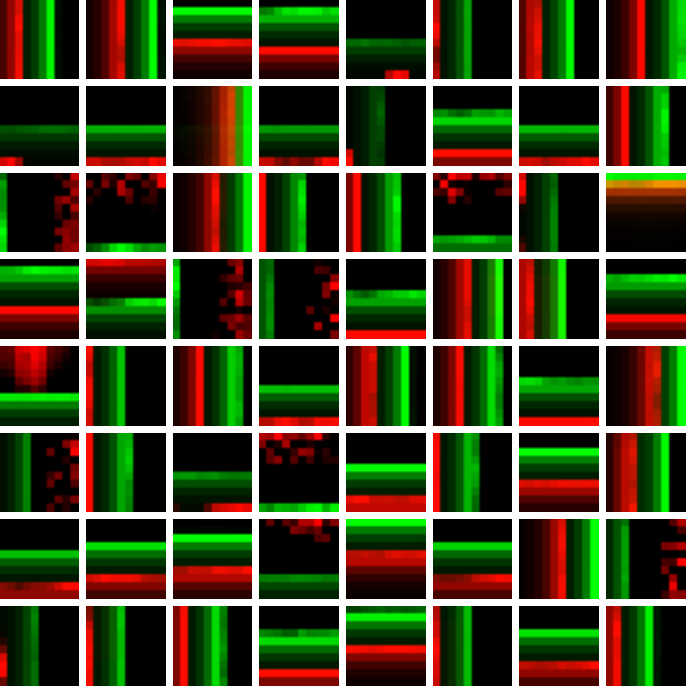

In [29]:
display_network([spinet])
convert_from_path(network_path + "figures/0/weight_sharing_0.pdf")[0].show()

## Network spike informations

Layer 1, nb neurons = 7168:


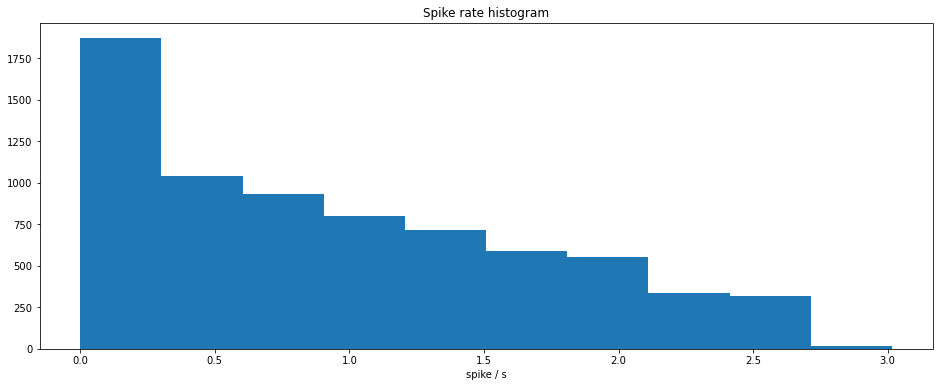

Layer 2, nb neurons = 112:


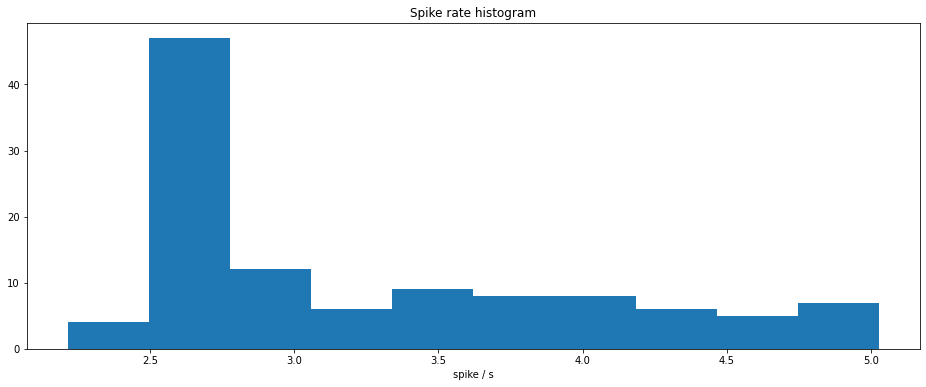

In [30]:
for layer, layer_spike_train in enumerate(spinet.spikes):
    print("Layer " + str(layer+1) + ", nb neurons = " + str(layer_spike_train.shape[0]) + ":")
    spike_rate_histogram(layer_spike_train, network_path + "/figures/"+str(layer)+"/sr_hist")

Layer 1, nb neurons = 7168:


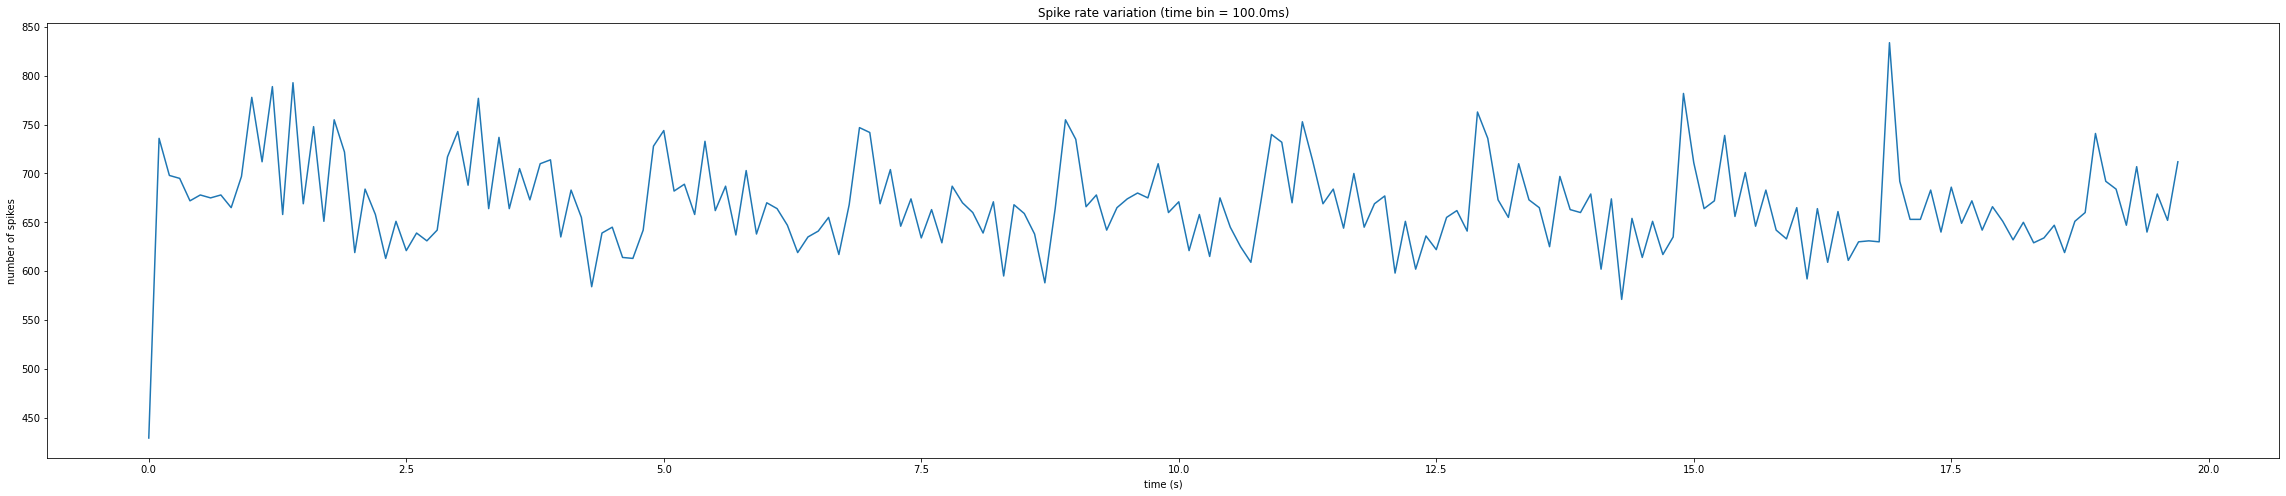

Layer 2, nb neurons = 112:


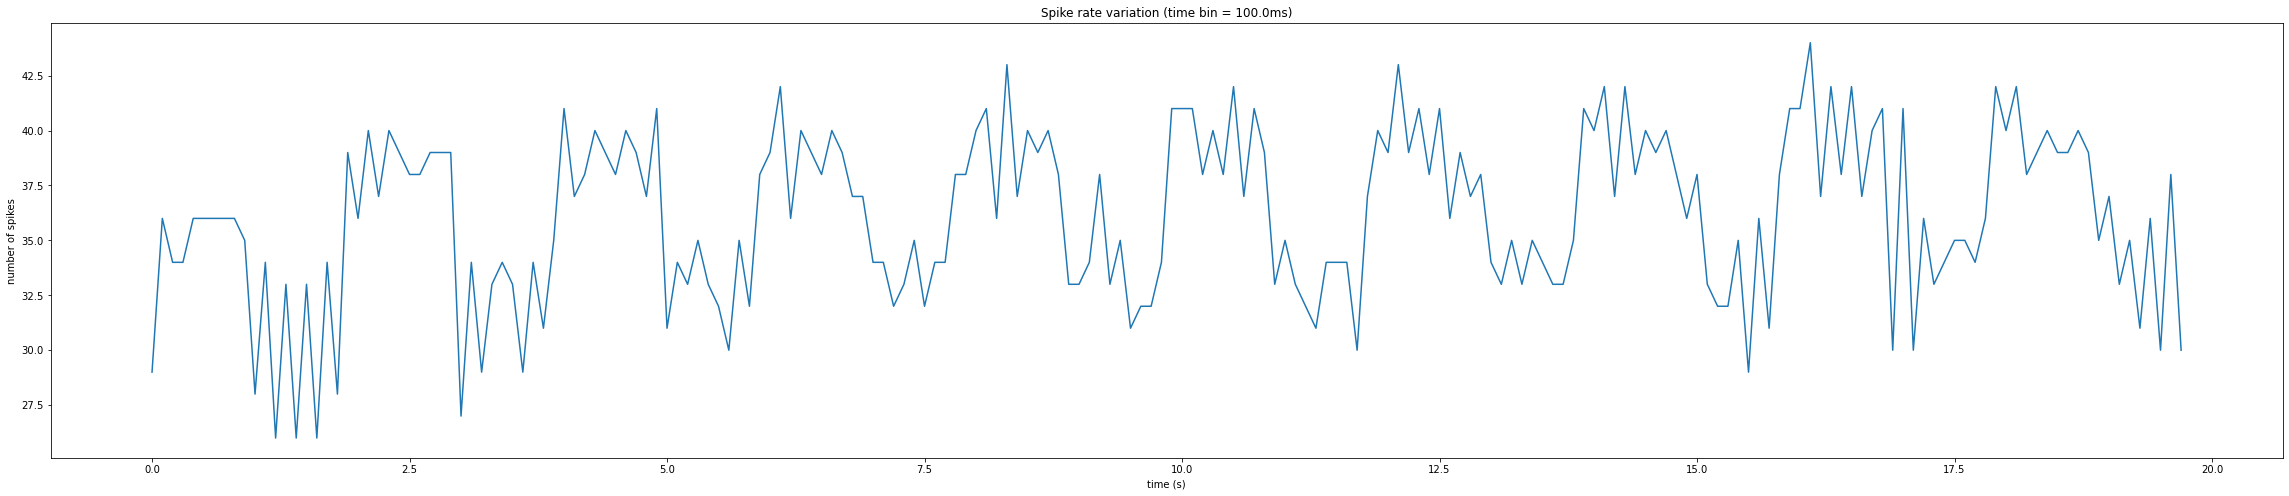

In [31]:
for layer, layer_spike_train in enumerate(spinet.spikes):
    print("Layer " + str(layer+1) + ", nb neurons = " + str(layer_spike_train.shape[0]) + ":")
    spike_rate_variation(layer_spike_train, 1e5, network_path + "/figures/"+str(layer)+"/sr_variation")

Layer 1, nb neurons = 7168:


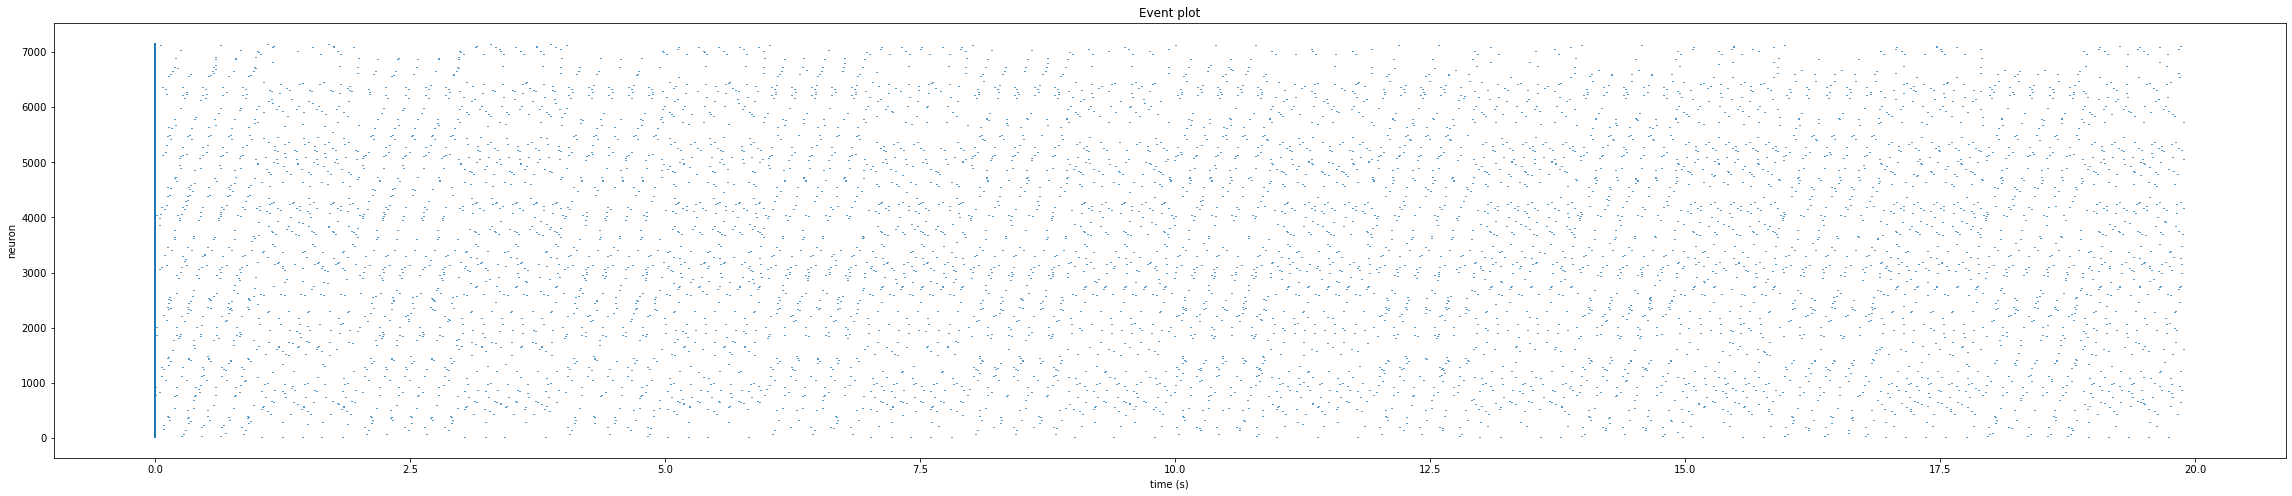

Layer 2, nb neurons = 112:


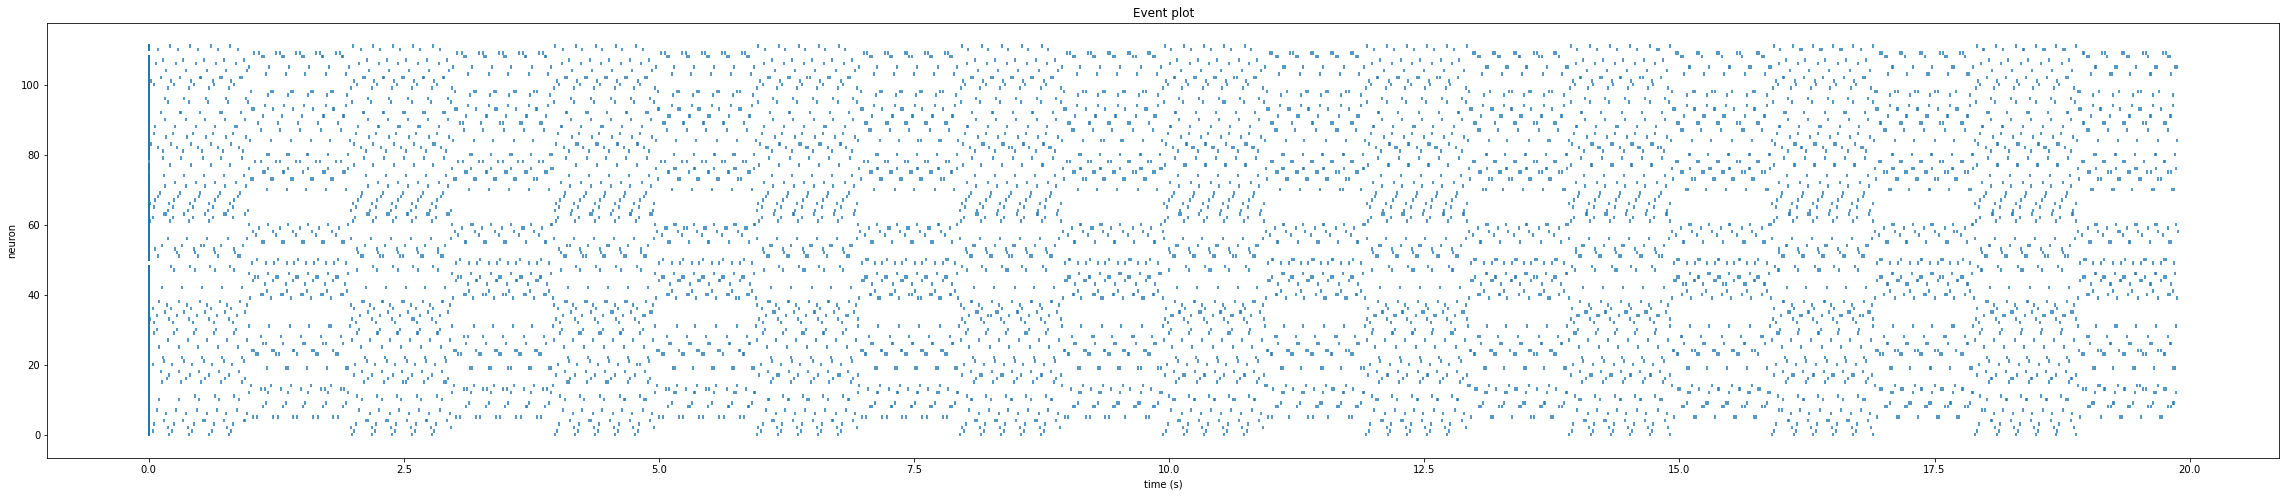

In [32]:
for layer, layer_spike_train in enumerate(spinet.spikes):
    print("Layer " + str(layer+1) + ", nb neurons = " + str(layer_spike_train.shape[0]) + ":")
    spike_plot(layer_spike_train, network_path + "/figures/"+str(layer)+"/sp_plot")

# !!! Delete Weights !!!

In [14]:
clean_network(network_path, [0, 1])

## Create networks

In [ ]:
# params = {"simple_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}, "complex_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}}
# create_networks(home + "neuvisys-dv/cmake-build-release", home + "Bureau", 2, {})
random_params("/home/thomas/neuvisys-dv/cmake-build-release", "/home/thomas/Desktop/Networks2", 40)

# Event manipulation:
Functions for loading, writing or creating event files in the different formats (aedat4, npz, rosbag...)

In [12]:
#Load events
events = load_aedat4(home + "Desktop/shape_hovering_fast.aedat4")

In [ ]:
# Save aedat file as numpy npz file
write_npz(home + "Desktop/shape_hovering_fast", events)  # mono
# write_npz(home + "Desktop/shapes", (left_events, right_events)) # stereo

In [3]:
# Load rosbag and convert it to npdat
left_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/left/events")
right_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/right/events")

FileNotFoundError: [Errno 2] No such file or directory: '/home/thomas/Downloads/outdoor_night1_data.bag'

## Load frames

In [ ]:
frames = load_frames("/media/alphat/DisqueDur/0_Thesis/pavin.aedat4")

## Create Matlab weight.mat

In [ ]:
basis = spinet.generate_weight_mat()

## Load various neuron informations

In [ ]:
simpa_decay, compa_decay = load_array_param(spinet, "learning_decay")
simpa_spike, compa_spike = load_array_param(spinet, "count_spike")

## Load and create gabor basis

In [ ]:
spinet.generate_weight_images()
gabor_params_l = create_gabor_basis(spinet, "None", nb_ticks=8)
# gabor_params_l = create_gabor_basis(spinet, "left/", nb_ticks=8)
# gabor_params_r = create_gabor_basis(spinet, "right/", nb_ticks=8)

## Create plots for preferred orientations and directions

In [ ]:
oris, oris_r = hists_preferred_orientations(spinet)
plot_preferred_orientations(spinet, oris, oris_r)

## Direction and orientation selectivity

In [ ]:
rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
dir_vec, ori_vec = complex_cells_directions(spinet, rotations)

angles = np.pi * rotations / 180

dirs = []
dis = []
for i in range(144):
    dirs.append(direction_norm_length(spinet.directions[:, i], angles))
    dis.append(direction_selectivity(spinet.directions[:, i]))
oris = []
ois = []
for i in range(144):
    oris.append(orientation_norm_length(spinet.orientations[:, i], angles[0:8]))
    ois.append(orientation_selectivity(spinet.orientations[:, i]))

## Network parameters

In [21]:
print("Network config:\n")
pprint.pprint(spinet.conf)
for layer in range(len(spinet.neurons)):
    print("\nLayer " + str(layer) + ":\n")
    pprint.pprint(spinet.neurons[layer][0].conf)

Network config:

{'V0': 0,
 'actionRate': 500,
 'decayRate': 0.01,
 'explorationFactor': 70,
 'interLayerConnections': [0, 0],
 'layerCellTypes': ['SimpleCell', 'ComplexCell'],
 'layerInhibitions': [True, True],
 'layerPatches': [[[33], [110], [0]], [[0], [0], [0]]],
 'layerSizes': [[28, 4, 64], [7, 1, 16]],
 'minActionRate': 100,
 'nbCameras': 1,
 'neuron1Synapses': 1,
 'neuronOverlap': [[0, 0, 0], [0, 0, 0]],
 'neuronSizes': [[10, 10, 1], [4, 4, 64]],
 'nu': 0.5,
 'saveData': True,
 'sharingType': 'patch',
 'tauR': 1}

Layer 0:

{'ETA_INH': 20,
 'ETA_LTD': -0.0021,
 'ETA_LTP': 0.0077,
 'ETA_RP': 1,
 'ETA_SRA': 0.6,
 'ETA_TA': 0,
 'MIN_THRESH': 4,
 'NORM_FACTOR': 4,
 'STDP_LEARNING': True,
 'SYNAPSE_DELAY': 0,
 'TARGET_SPIKE_RATE': 0.75,
 'TAU_LTD': 14,
 'TAU_LTP': 7,
 'TAU_M': 18,
 'TAU_RP': 30,
 'TAU_SRA': 100,
 'TRACKING': 'partial',
 'VRESET': -20,
 'VTHRESH': 30}

Layer 1:

{'ETA_INH': 15,
 'ETA_LTD': 0.2,
 'ETA_LTP': 0.2,
 'ETA_RP': 1,
 'NORM_FACTOR': 10,
 'STDP_LEARNING': True,

## Create event videos

Generate frames of the desired visual stimuli, then convert those frames into an event stream

In [2]:
framerate = 1000
time_gap = 1e6 * 1 / framerate
folder = home + "Desktop/Events/"

In [5]:
moving_lines(folder, time=1, framerate=framerate, rotation=0, frame_start=0)

In [12]:
disparity_bars(folder, disparities=[0, 0, 0, 0], framerate=framerate)
disparity_bars(folder, disparities=[8, 6, 4, 2], framerate=framerate)

In [ ]:
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    moving_lines(folder + str(rotation) + "/", rotation=rotation, framerate=framerate)

In [6]:
pix2eve = Pix2Eve(
    folder,
    time_gap=time_gap,
    log_threshold=0,
    map_threshold=0.4,
    n_max=5,
    adapt_thresh_coef_shift=0.05,
)
events = pix2eve.run()
events = events[events[:, 0].argsort()]

0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion


In [7]:
write_npz(home + "/Desktop/vhlines", events)